Disclosure Analysis
---

Author: Peter Zhang

Analysis of disclosure and Tabroom results.

### Setup

#### Imports

In [1]:
import csv
from datetime import datetime, timedelta
from matplotlib import pyplot as plt 
import numpy as np

In C:\Users\thepe\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\thepe\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\thepe\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\thepe\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\thepe\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mpl

#### Settings

- WIKIPATH describes the location of wiki databases
- WIKIPAGES are the wiki pages to load
- TABPATH is the location of the Tabroom data

In [12]:
WIKIPATH = "wiki_data/"
WIKIPAGES = ["LD14", "LD15", "LD16", "LD17", "LD18", "LD19", "LD20", 'PF17', "PF18", "PF19", "PF20"]

In [13]:
schoolData = []
teamData = []
for wikipage in WIKIPAGES:
    with open(WIKIPATH + wikipage + "schools_wiki.csv", 'r', encoding = 'utf-8-sig') as inFile:
        for row in csv.DictReader(inFile):
            row['Wiki'] = wikipage
            schoolData.append(row)
    with open(WIKIPATH + wikipage + "teams_wiki.csv", 'r', encoding = 'utf-8-sig') as inFile:
        for row in csv.DictReader(inFile):
            row['Wiki'] = wikipage
            teamData.append(row)

In [14]:
TABPATH = "tab_data/"

In [15]:
with open(TABPATH + 'disclosure_entries.csv', 'r') as inFile:
    entriesData = [row for row in csv.DictReader(inFile)]
with open(TABPATH + 'disclosure_info.csv', 'r', encoding = 'utf-8-sig') as inFile:
    infoData = [row for row in csv.DictReader(inFile)]

In [16]:
teamData = [team for team in teamData if ' - ' in team['Team Name']]

In [17]:
wikiSchools = set([team['Team Name'].split(" - ")[0] for team in teamData])
wikiNames = set([team['Team Name'].split(" - ")[1] for team in teamData])

In [18]:
entrySchools = set([entry['School'] for entry in entriesData])

### Analysis

#### Preprocessing

In [19]:
# get seasons
for tourn in infoData:
    monthday = tourn['Dates'].split(" to ")[0]
    year = tourn['Tourn Name'][-2:]
    tournDate = datetime.strptime(monthday + "/" + year, '%m/%d/%y')
    tourn['Start Date'] = tournDate
    tourn['Season'] = (tournDate - timedelta(days=150)).year
    
# dictionary for easy indexing
getInfo = dict([[tourn['Tourn Name'], tourn] for tourn in infoData])

In [20]:
teamIndex = {}
for team in teamData:
    wiki = team["Wiki"]
    if wiki[:2] == "LD":
        school = team['Team Name'].split(" - ")[0]
        name = team['Team Name'].split(" - ")[1]
    else:
        school = " ".join(team['School'].split()[:-1])
        name = team['Team Name'].replace(school, "").strip()
        name = " & ".join([n.split()[-1] for n in name.split(" - ") if len(n.split()) > 0])
    if wiki not in teamIndex:
        teamIndex[wiki] = {}
    if name not in teamIndex[wiki]:
        teamIndex[wiki][name] = []
    
    team['School'] = school
    team['Team Name'] = name
    
    teamIndex[wiki][name].append(team)

In [21]:
# match disclosure
for entry in entriesData:
    season = getInfo[entry['Tournament']]['Season']
    wiki = entry['Event'][-2:] + str(season)[-2:]
    if wiki in teamIndex:
        teams = teamIndex[wiki]
        if entry['Name'] in teams:
            for team in teams[entry['Name']]:
                if team['School'] in entry['School']:
                    if team['Side'] == 'Aff':
                        entry['Aff Wiki'] = team
                    else:
                        entry['Neg Wiki'] = team
    if 'Aff Wiki' not in entry:
        entry['Aff Wiki'] = None
    if 'Neg Wiki' not in entry:
        entry['Neg Wiki'] = None

In [22]:
for entry in entriesData:
    aff = entry['Aff Wiki']
    neg = entry['Neg Wiki']
    if aff and neg:
        team = aff['Team Name']
        school = aff['School']
        rounds = str(eval(aff['Rounds']) + eval(neg['Rounds']))
        rr = str(eval(aff['Round Reports']) + eval(neg['Round Reports']))
        cites = str(eval(aff['Cites']) + eval(neg['Cites']))
        wiki = aff['Wiki']
        entry['Disclosure'] = {'Team Name':team,
                              'School':school,
                              'Rounds':rounds,
                              'Round Reports':rr,
                              'Cites':cites,
                              'Wiki':wiki}
    else:
        entry['Disclosure'] = None

#### Yearly

In [943]:
seasons = range(2015, 2021)
# yearly stats
yearly_entries = dict([[season, 0] for season in seasons])
yearly_cites = dict([[season, 0] for season in seasons])
yearly_RR = dict([[season, 0] for season in seasons])
yearly_osource = dict([[season, 0] for season in seasons])
yearly_RR_shell = dict([[season, 0] for season in seasons])
yearly_os_shell = dict([[season, 0] for season in seasons])
yearly_newaffs_shell = dict([[season, 0] for season in seasons])
yearly_fulltext_shell = dict([[season, 0] for season in seasons])
yearly_disc_shell = dict([[season, 0] for season in seasons])

In [944]:
os_names = ["open source", "osource", "opensource"]
fulltext_names = ["full text", "fulltext"]
RR_names = ["round reports", "roundreports"]
newaffs_names = ["new affs", "newaff"]
disc_names = ["cites", 'disclosure', 'disclose', 'or lose', 'wiki']

In [945]:
for entry in entriesData:
    disclosure = entry['Disclosure']
    tourn = entry['Tournament']
    # varisty
    if entry['Event'] == 'VLD':
        season = getInfo[tourn]['Season']
        if season in seasons:
            yearly_entries[season] += 1
            if disclosure:
                if eval(disclosure['Cites']):
                    yearly_cites[season] += 1
                if eval(disclosure['Round Reports']):
                    yearly_RR[season] += 1
                rounds = eval(disclosure['Rounds'])
                if any(['.docx' in r[4] for r in rounds]):
                    yearly_osource[season] += 1
                if any([d in disclosure['Cites'].lower() for d in disc_names]):
                    yearly_disc_shell[season] += 1
                if any([rr in disclosure['Cites'].lower() for rr in RR_names]):
                    yearly_RR_shell[season] += 1
                if any([os in disclosure['Cites'].lower() for os in os_names]):
                    yearly_os_shell[season] += 1
                if any([na in disclosure['Cites'].lower() for na in newaffs_names]):
                    yearly_newaffs_shell[season] += 1
                if any([ft in disclosure['Cites'].lower() for ft in fulltext_names]):
                    yearly_fulltext_shell[season] += 1

In [946]:
print("Entries:",yearly_entries)
print("Cites:", yearly_cites)
print("Round reports:", yearly_RR)
print("Open source:",yearly_osource)
print("Disc shell:", yearly_disc_shell)
print("RR shell:",yearly_RR_shell)
print("Osource shell:",yearly_os_shell)
print("New affs:",yearly_newaffs_shell)
print("Full text:",yearly_fulltext_shell)

Entries: {2015: 3073, 2016: 3804, 2017: 4034, 2018: 4376, 2019: 4768, 2020: 3664}
Cites: {2015: 1156, 2016: 1559, 2017: 2223, 2018: 2406, 2019: 2742, 2020: 2441}
Round reports: {2015: 509, 2016: 733, 2017: 1249, 2018: 1650, 2019: 2214, 2020: 2176}
Open source: {2015: 190, 2016: 270, 2017: 779, 2018: 1412, 2019: 2209, 2020: 2173}
Disc shell: {2015: 338, 2016: 536, 2017: 763, 2018: 1007, 2019: 1017, 2020: 1193}
RR shell: {2015: 6, 2016: 6, 2017: 5, 2018: 48, 2019: 70, 2020: 118}
Osource shell: {2015: 24, 2016: 7, 2017: 46, 2018: 199, 2019: 260, 2020: 247}
New affs: {2015: 0, 2016: 6, 2017: 65, 2018: 179, 2019: 356, 2020: 500}
Full text: {2015: 7, 2016: 0, 2017: 88, 2018: 98, 2019: 57, 2020: 34}


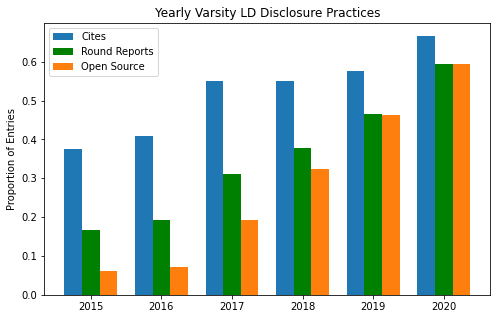

In [947]:
# annual visualization
plt.figure(figsize=(8,5))

N = len(seasons)
cites_plotdata = [yearly_cites[t]/yearly_entries[t] for t in seasons]
RR_plotdata = [yearly_RR[t]/yearly_entries[t] for t in seasons]
osource_plotdata = [yearly_osource[t]/yearly_entries[t] for t in seasons]

ind = np.arange(N) 
width = 0.25    
plt.bar(ind, cites_plotdata, width,
        label='Cites')
plt.bar(ind + width, RR_plotdata, width,
    label='Round Reports',
       color='g')
plt.bar(ind + 2*width, osource_plotdata, width,
    label='Open Source')

plt.ylabel('Proportion of Entries')
plt.title('Yearly Varsity LD Disclosure Practices')

plt.xticks(ind + width, seasons)
plt.legend(loc='best')
plt.show()

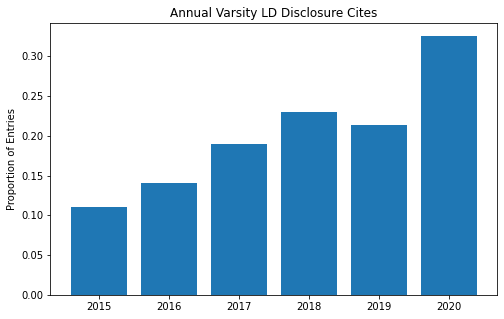

In [948]:
# annual visualization
plt.figure(figsize=(8,5))

N = len(seasons)
disc_plotdata = [yearly_disc_shell[t]/yearly_entries[t] for t in seasons]

ind = np.arange(N) 
width = 0.8
plt.bar(ind + 0.8, disc_plotdata, width,
        label='Cites')

plt.ylabel('Proportion of Entries')
plt.title('Annual Varsity LD Disclosure Cites')

plt.xticks(ind + width, seasons)
plt.show()

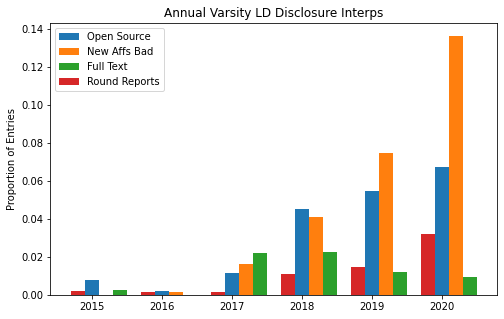

In [949]:
# annual visualization
plt.figure(figsize=(8,5))

N = len(seasons)
RRshell_plotdata = [yearly_RR_shell[t]/yearly_entries[t] for t in seasons]
osshell_plotdata = [yearly_os_shell[t]/yearly_entries[t] for t in seasons]
newaffsshell_plotdata = [yearly_newaffs_shell[t]/yearly_entries[t] for t in seasons]
fulltextshell_plotdata = [yearly_fulltext_shell[t]/yearly_entries[t] for t in seasons]

ind = np.arange(N) 
width = 0.2  
plt.bar(ind + width, osshell_plotdata, width,
    label='Open Source')
plt.bar(ind + 2*width, newaffsshell_plotdata, width,
    label='New Affs Bad')
plt.bar(ind + 3*width, fulltextshell_plotdata, width,
    label='Full Text')
plt.bar(ind, RRshell_plotdata , width,
        label='Round Reports')

plt.ylabel('Proportion of Entries')
plt.title('Annual Varsity LD Disclosure Interps')

plt.xticks(ind + width, seasons)
plt.legend(loc='best')
plt.show()

#### Divisions

In [950]:
# yearly stats
yearly_entries = dict([[season, 0] for season in seasons])
yearly_cites = dict([[season, 0] for season in seasons])
yearly_RR = dict([[season, 0] for season in seasons])
yearly_osource = dict([[season, 0] for season in seasons])

In [951]:
for entry in entriesData:
    disclosure = entry['Disclosure']
    tourn = entry['Tournament']
    # varisty
    if entry['Event'] == 'JVLD' or entry['Event'] == 'NLD':
        season = getInfo[tourn]['Season']
        if season in seasons:
            yearly_entries[season] += 1
            if disclosure:
                if eval(disclosure['Cites']):
                    yearly_cites[season] += 1
                if eval(disclosure['Round Reports']):
                    yearly_RR[season] += 1
                rounds = eval(disclosure['Rounds'])
                if any(['.docx' in r[4] for r in rounds]):
                    yearly_osource[season] += 1
                if any([rr in disclosure['Cites'].lower() for rr in RR_names]):
                    yearly_RR_shell[season] += 1
                if any([os in disclosure['Cites'].lower() for os in os_names]):
                    yearly_os_shell[season] += 1
                if any([na in disclosure['Cites'].lower() for na in newaffs_names]):
                    yearly_newaffs_shell[season] += 1
                if any([ft in disclosure['Cites'].lower() for ft in fulltext_names]):
                    yearly_fulltext_shell[season] += 1

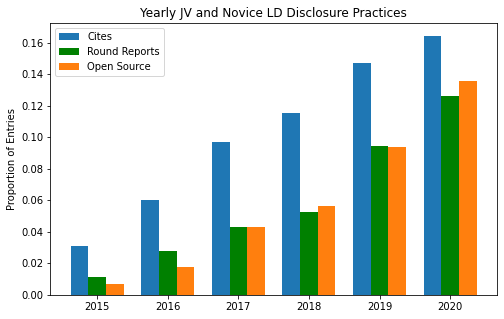

In [952]:
# annual visualization
plt.figure(figsize=(8,5))

N = len(seasons)
cites_plotdata = [yearly_cites[t]/yearly_entries[t] for t in seasons]
RR_plotdata = [yearly_RR[t]/yearly_entries[t] for t in seasons]
osource_plotdata = [yearly_osource[t]/yearly_entries[t] for t in seasons]

ind = np.arange(N) 
width = 0.25    
plt.bar(ind, cites_plotdata, width,
        label='Cites')
plt.bar(ind + width, RR_plotdata, width,
    label='Round Reports',
       color='g')
plt.bar(ind + 2*width, osource_plotdata, width,
    label='Open Source')

plt.ylabel('Proportion of Entries')
plt.title('Yearly JV and Novice LD Disclosure Practices')

plt.xticks(ind + width, seasons)
plt.legend(loc='best')
plt.show()

In [906]:
print(cites_plotdata)
print(RR_plotdata)
print(osource_plotdata)

[0.06036536934074663, 0.09667896678966789, 0.11547525530243519, 0.14683053040103494, 0.16420503909643788]
[0.02779984114376489, 0.042804428044280446, 0.05263157894736842, 0.0944372574385511, 0.1259774109470026]
[0.017474185861795076, 0.042804428044280446, 0.056559308719560095, 0.09379042690815007, 0.1355343179843614]


#### Tournament

In [907]:
# tournament stats
tourn_names = [tourn['Tourn Name'][:-2] for tourn in infoData if tourn['Season'] == 2019]
tourn_entries = dict([[tourn, 0] for tourn in tourn_names])
tourn_cites = dict([[tourn, 0] for tourn in tourn_names])
tourn_RR = dict([[tourn, 0] for tourn in tourn_names])
tourn_osource = dict([[tourn, 0] for tourn in tourn_names])

In [908]:
for entry in entriesData:
    disclosure = entry['Disclosure']
    tourn = entry['Tournament'][:-2]
    season = getInfo[entry['Tournament']]['Season']
    if season == 2019 and entry['Event'] == 'VLD':
        tourn_entries[tourn]+= 1
        if disclosure:
            if eval(disclosure['Cites']):
                tourn_cites[tourn] += 1
            if eval(disclosure['Round Reports']):
                tourn_RR[tourn] += 1
            rounds = eval(disclosure['Rounds'])
            if any(['.docx' in r[4] for r in rounds]):
                tourn_osource[tourn] += 1

In [909]:
graph_tourns = sorted([t for t in tourn_names if tourn_entries[t]], key = lambda x: tourn_cites[x]/tourn_entries[x])

In [910]:
# name corrections, if necessary
fixName = {
    "heritagehall" : "Heritage Hall",
    "usc" : "USC",
    "UT" : "UT",
    "bluekey" : "Blue Key",
    "cypress" : "Cypress Bay",
    'cps' : "College Prep",
    'applevalley' : "Apple Valley",
    'holycross' : "Holy Cross",
    "jackhowe" : "Jack Howe",
    'uk': "UK",
    'hwestlake':'Harvard Westlake',
    'millardnorth': 'Millard North',
    'myerspark':'Myers Park',
    'goldendesert':'Golden Desert',
    'longbeach':'Long Beach',
    'asu' : "ASU",
    'lewisandclark':'Lewis and Clark',
    'pugetsound':'Puget Sound'
}

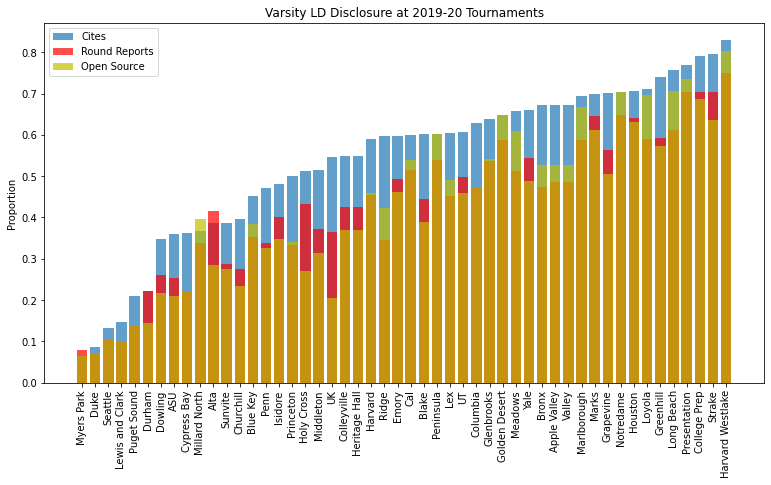

In [911]:
# plot of changes in participation
fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([0,0,1,1])
ax.bar([fixName[t] if t in fixName else t.title() for t in graph_tourns],
       [tourn_cites[t]/tourn_entries[t] for t in graph_tourns],
      alpha=0.7)
ax.bar([fixName[t] if t in fixName else t.title() for t in graph_tourns],
       [tourn_RR[t]/tourn_entries[t] for t in graph_tourns],
       color='r',
      alpha=0.7)
ax.bar([fixName[t] if t in fixName else t.title() for t in graph_tourns],
       [tourn_osource[t]/tourn_entries[t] for t in graph_tourns],
      alpha=0.7,
      color='y')
plt.title("Varsity LD Disclosure at 2019-20 Tournaments")
plt.ylabel("Proportion")
plt.xticks(rotation='vertical')
plt.legend(['Cites', 'Round Reports', 'Open Source'])
plt.show()

In [821]:
seasons = [2014, 2015, 2016, 2017, 2018, 2019]
# yearly stats
HW_entries = dict([[season, 0] for season in seasons])
HW_cites = dict([[season, 0] for season in seasons])
HW_RR = dict([[season, 0] for season in seasons])
HW_osource = dict([[season, 0] for season in seasons])

In [822]:
for entry in entriesData:
    disclosure = entry['Disclosure']
    tourn = entry['Tournament']
    season = getInfo[tourn]['Season']
    if entry['Event'] == 'NLD' and entry['Tournament'][:-2] == 'hwestlake':
        HW_entries[season]+= 1
        if disclosure:
            if eval(disclosure['Cites']):
                HW_cites[season] += 1
            if eval(disclosure['Round Reports']):
                HW_RR[season] += 1
            rounds = eval(disclosure['Rounds'])
            if any(['.docx' in r[4] for r in rounds]):
                HW_osource[season] += 1

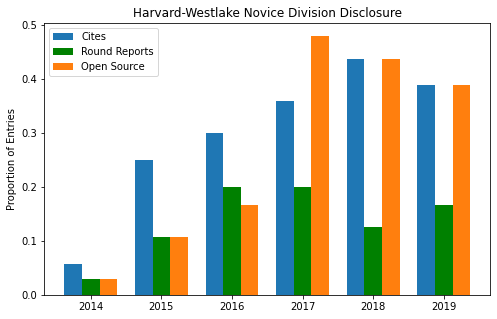

In [823]:
# annual visualization
plt.figure(figsize=(8,5))

N = len(seasons)
citesHW_plotdata = [HW_cites[t]/HW_entries[t] for t in seasons]
RRHW_plotdata = [HW_RR[t]/HW_entries[t] for t in seasons]
osourceHW_plotdata = [HW_osource[t]/HW_entries[t] for t in seasons]

ind = np.arange(N) 
width = 0.25    
plt.bar(ind, citesHW_plotdata, width,
        label='Cites')
plt.bar(ind + width, RRHW_plotdata, width,
    label='Round Reports',
       color='g')
plt.bar(ind + 2*width, osourceHW_plotdata, width,
    label='Open Source')

plt.ylabel('Proportion of Entries')
plt.title('Harvard-Westlake Novice Division Disclosure')

plt.xticks(ind + width, seasons)
plt.legend(loc='best')
plt.show()

#### Schools

In [912]:
school_cites = {}
school_RR = {}
school_osource = {}
for team in teamData:
    if team['Wiki'][:2] == 'LD':
        school = team['School']
        num_cites = len(eval(team['Cites']))
        rounds = eval(team['Rounds'])
        num_osource = len([r for r in rounds if '.docx' in r[4]])
        num_RR = len([rr for rr in eval(team['Round Reports']) if rr])
        if num_cites:
            if school in school_cites:
                school_cites[school] += num_cites
            else:
                school_cites[school] = num_cites

        if num_RR:
            if school in school_RR:
                school_RR[school] += num_RR
            else:
                school_RR[school] = num_RR

        if num_osource:
            if school in school_osource:
                school_osource[school] += num_osource
            else:
                school_osource[school] = num_osource
        if "debatedrills" in team['Cites'].lower():
            school = "DebateDrills"
            if num_cites:
                if school in school_cites:
                    school_cites[school] += num_cites
                else:
                    school_cites[school] = num_cites

            if num_RR:
                if school in school_RR:
                    school_RR[school] += num_RR
                else:
                    school_RR[school] = num_RR

            if num_osource:
                if school in school_osource:
                    school_osource[school] += num_osource
                else:
                    school_osource[school] = num_osource

In [913]:
school_names = sorted(school_cites.keys(), key = lambda x: school_cites[x], reverse=True)[:50]

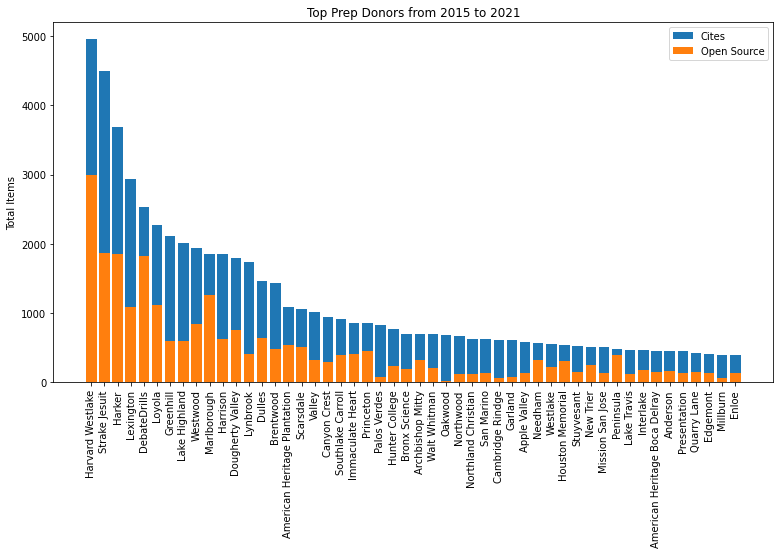

In [914]:
# plot of changes in participation
fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([0,0,1,1])
ax.bar(school_names,
       [school_cites[school] for school in school_names],
      label = 'Cites')
ax.bar(school_names,
       [school_osource[school] for school in school_names],
      label = 'Open Source')
plt.title("Top Prep Donors from 2015 to 2021")
plt.ylabel("Total Items")
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

#### Public Forum

In [827]:
# yearly stats
seasons = [2017, 2018, 2019, 2020]
yearly_entries = dict([[season, 0] for season in seasons])
yearly_cites = dict([[season, 0] for season in seasons])
yearly_RR = dict([[season, 0] for season in seasons])
yearly_osource = dict([[season, 0] for season in seasons])

In [828]:
for entry in entriesData:
    disclosure = entry['Aff Wiki']
    tourn = entry['Tournament']
    # varisty
    if entry['Event'] == 'VPF':
        season = getInfo[tourn]['Season']
        if season in seasons:
            yearly_entries[season] += 1
            if disclosure:
                if eval(disclosure['Cites']):
                    yearly_cites[season] += 1
                if eval(disclosure['Round Reports']):
                    yearly_RR[season] += 1
                rounds = eval(disclosure['Rounds'])
                if any(['.docx' in r[4] for r in rounds]):
                    yearly_osource[season] += 1
                if any([rr in disclosure['Cites'].lower() for rr in RR_names]):
                    yearly_RR_shell[season] += 1
                if any([os in disclosure['Cites'].lower() for os in os_names]):
                    yearly_os_shell[season] += 1
                if any([na in disclosure['Cites'].lower() for na in newaffs_names]):
                    yearly_newaffs_shell[season] += 1
                if any([ft in disclosure['Cites'].lower() for ft in fulltext_names]):
                    yearly_fulltext_shell[season] += 1

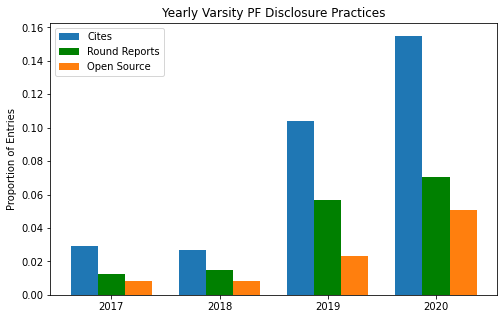

In [829]:
# annual visualization
plt.figure(figsize=(8,5))

N = len(seasons)
cites_plotdata = [yearly_cites[t]/yearly_entries[t] for t in seasons]
RR_plotdata = [yearly_RR[t]/yearly_entries[t] for t in seasons]
osource_plotdata = [yearly_osource[t]/yearly_entries[t] for t in seasons]

ind = np.arange(N) 
width = 0.25    
plt.bar(ind, cites_plotdata, width,
        label='Cites')
plt.bar(ind + width, RR_plotdata, width,
    label='Round Reports',
       color='g')
plt.bar(ind + 2*width, osource_plotdata, width,
    label='Open Source')

plt.ylabel('Proportion of Entries')
plt.title('Yearly Varsity PF Disclosure Practices')

plt.xticks(ind + width, seasons)
plt.legend(loc='best')
plt.show()